# TensorFlow RNN tutorial

# 1 Hello world

In [1]:
import tensorflow as tf

In [2]:
hello = tf.constant('TensorFlow helps the tensors flow.')

In [3]:
sess = tf.Session()

In [4]:
print sess.run(hello)
sess.close()

TensorFlow helps the tensors flow.


# 3 RNNs

In [11]:
%reset -f
%matplotlib inline

In [16]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # For constructing fun signals.
import seaborn as sns

Note: You do not need `rnn` and `rnn_cell` from `tensorflow.models.rnn` in order to implement RNNs using TensorFlow. These modules are useful abstractions, but you can also implement RNNs 'by hand'. It is worth reading the `rnn.py` and `rnn_cell.py` files -- they are simple -- to get a sense of what they do.

In short, `rnn.py` essentially takes the "cell" specified by `rnn_cell.py` and creates the computational graph by unrolling in time. Once unrolled, the "cell" is now a layer in a deep network.

### Create input and output data:

For this tutorial, we will work with simple signals, an input $u(t)\in\mathbb{R}^m$ and an output $y(t)\in\mathbb{R}^p$, usually simple sinusoids, square waves, etc, in discrete time, and for $T$ time steps. As matrices, we have our dataset: $U\in\mathbb{R}^{T\times m}$ and $Y\in\mathbb{R}^{T\times p}$.

We will eventually need to split signals into smaller sized-batches of size $T_{\text{batch}}\times m$. Thus, a training example will be a subsequence of the full, length-$T$ dataset. Some datasets are naturally split into different batches. Here we will consider one length-$T$ dataset without loss of intuition.

In [17]:
# Signal parameters
cycle = 50 # cycle length
T = 5*cycle # total time
t = np.arange(T)

In [18]:
def rand_signal(time_, cycle_, components_):
    """ 
    Create a size (T,) signal with lognormal distribution of component frequencies.
    """
    freq = 2*np.pi/cycle_*np.random.lognormal(mean=0, size=components_)
    phi = np.random.rand(components_)*cycle_
    z = np.sin(np.outer(time_, freq) + phi)
    z = z.sum(axis=1) # add up the sinusoids 
    z = (z - z.min()) / (z.max() - z.min()) # normalize
    z = 2*z - 1 # set range to [-1,1]
    return z

In [19]:
# Create different signals to play with
# Each signal set, z_*, will be size (T,n_sig)
n_sig = 10 
freq = 2*np.pi/cycle*np.linspace(1,5,n_sig)

# ∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿
phi = np.random.rand(n_sig)*cycle
z_sin = np.sin(np.outer(t,freq) + phi)

# ◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻
phi = np.random.rand(n_sig)*cycle
z_square = signal.square(np.outer(t,freq) + phi)

# |/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|
phi = np.random.rand(n_sig)*cycle
z_saw = signal.sawtooth(np.outer(t,freq) + phi)

# ◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻
freq = 2*np.pi/cycle*np.linspace(5,20,n_sig)
phi = np.random.rand(n_sig)*cycle
z_modsq = signal.square(np.outer(freq,t) + phi.reshape([-1,1]),
                        duty=(0.5*np.sin(2*np.pi/cycle* 1 *t)+0.5))
z_modsq = z_modsq.T

# @.^;{&(*[\"@@{£*|'}{('£?}@*+.#~=@*+^%[&_
z_psrnd = 2*np.round(np.random.rand(T,n_sig))-1

# ∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿
z_randsin = np.zeros((T,n_sig))
for i in range(n_sig):
    z_randsin[:,i] = rand_signal(t, cycle, 10)

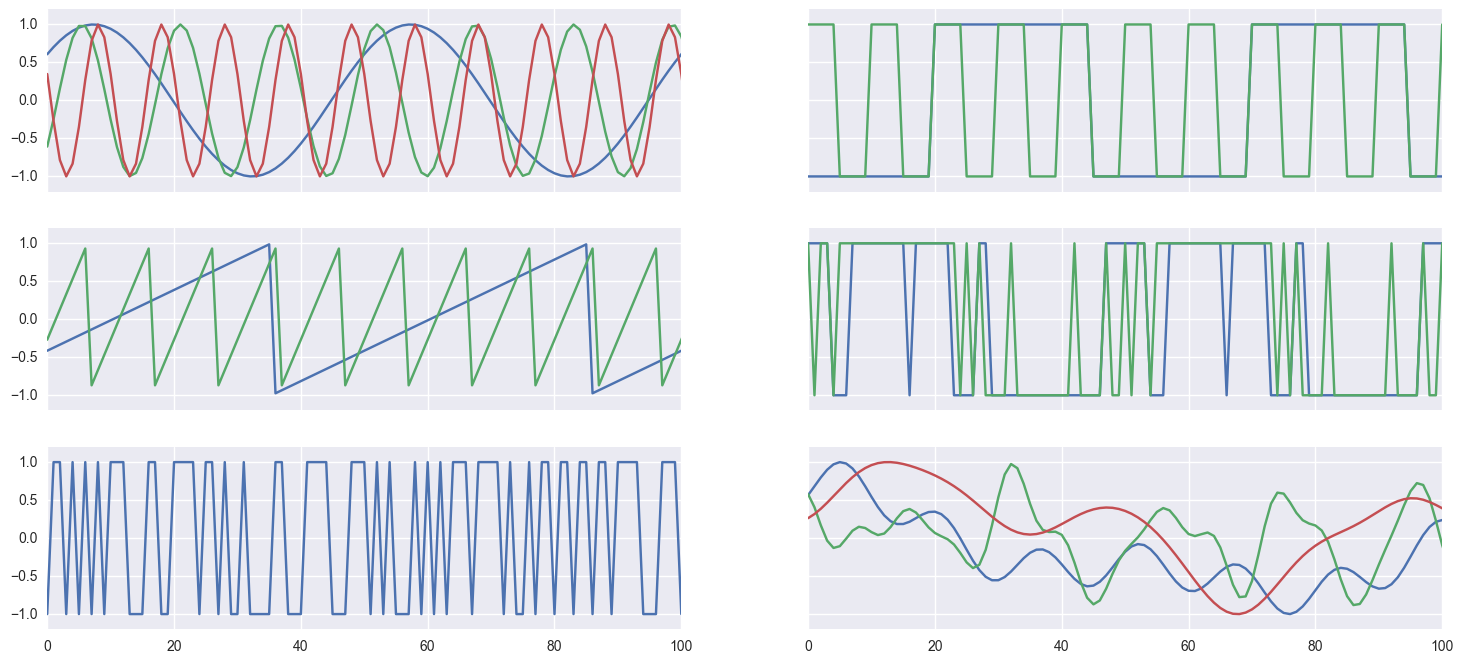

In [20]:
# Plot signals
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='row', figsize=(18,8),
                                                  subplot_kw=dict(xlim=(0,2*cycle),
                                                                  ylim=(-1.2,1.2)))
ax1.plot(z_sin[:,[0,5,9]])
ax2.plot(z_square[:,[0,9]])
ax3.plot(z_saw[:,[0,9]])
ax4.plot(z_modsq[:,[0,9]])
ax5.plot(z_psrnd[:,[0]])
ax6.plot(z_randsin[:,[0,1,2]])
plt.show()

### RNNs:
Our goal is to fit a function, called a (dynamical) system, $F:\mathbb{R}^{T\times m}\rightarrow \mathbb{R}^{T\times p}$, using our input and output data, $U\in\mathbb{R}^{T\times m}$ and $Y\in\mathbb{R}^{T\times p}$. Generally, datapoints may depend on other datapoints from time steps far away. E.g. $y(t)$ may depend somehow on $u(t-10)$ or on $y(t+5)$. RNNs -- more generally, state-space models -- replace all higher-order dependencies with first-order dependencies via a standard mathematical trick: introduce a new, possibly high-dimensional, latent variable $x$. The rough intuition from linear systems is a 10th-order dependence in $F$ requires $x$ to be at least 10-dimensional. As a bonus, state-space models give a realization of $F$ that is causal (nowhere do variables explicitly depend on the future).

The term "order" is used in the preceding paragraph because the shift operator $\sigma x(t) = x(t+1)$ can be thought of as a discrete-time analog of a derivative and $\sigma^{10}x(t)$ would be a "10th order" term in a model.

An RNN is a nonlinear [realization](https://en.wikipedia.org/wiki/Realization_%28systems%29) of $F$, and is written,

$$
\begin{align}
    x(t+1) &= f(Ax(t) + Bu(t) + b) \\
    y(t) &= Cx(t) + c
\end{align}
$$

with $u\in\mathbb{R}^m$, $x\in\mathbb{R}^n$, $y\in\mathbb{R}^p$, matrices of apporpriate dimensions, and $t=0,\dots\,T-1$

Here, $u$, $y$, $f$ are all known, and we estimate $A$, $B$, $b$, $C$, $c$. We also estimate $x(0)$, which for deterministic systems (like the one written above) uniquely determines $x(t)$ for all $t$. For stochastic systems we need to be careful about the interaction of the system itself and its state sequence. Proper estimation of $x$ requires filtering. (Kalman) filtering can be used in the model validation step, and for some types of problems will be very important.

It is possible to fit $F$ directly without introducing a latent variable. See the NARMAX literature, for example.

#### Some TensorFlow RNN basics:
* A *batch* is a size $T_\text{batch}\times n$ signal.
* Standard: use the variable name `num_steps` to refer to $T_\text{batch}$.
* Standard: use the variable name `batch_size` to refer to the number of batches that are optimized over in parallel in one optimization step.

Suppose we had one long $U\in\mathbb{R}^{T\times m}$ input signal and one $Y\in\mathbb{R}^{T\times p}$ output signal. Let us consider four strategies for fitting the function $F:U\rightarrow Y$ using RNNs. Suppose `T=100`.

#### Batch strategies:

1. Set `num_steps=100` and `batch_size=1`.
2. Set `num_steps=20` and `batch_size=5` and split the batches evenly.    
3. Set, say, `num_steps=10` and `batch_size=5`, and let each batch be randomly chosen (one new batch selection per optimization step).
4. Set, say, `num_steps=10` and `batch_size=T-num_steps=90`, and consider every possible batch.

Strategy 1 requires BPTT through 100 time steps. Have to estimate x(0)

Strategy 2: Batch 1 is `t=0` to `t=19`, batch 2 is `t=20` to `t=39`, etc. At each optimization step we use the same 5 batches. By default, the optimization never tries to fit the transition from `t=19` to `t=20`. We esimate the state variable at times `t=0,20,40,..`. These are our initial states, one per batch. To fit the transition from `t=19` to `t=20` we can use the final state of batch 1 as the initial state of batch 2. Thus, we only have to estimate $x(0)$. 
    
Strategy 3 is SGD. Randomly choose 5 initial time points ranging from `0` to `T-num_steps` to specify 5 batches. There will likely be some overlapping batches. For one optimization step, esimate the corresponding initial states. For the next optimization step, we select a different set of 5 batches and estimate their corresponding initial states. Instead of estimating the initial state each time, we can store an estimate of the entire state sequence, by using the state sequences from individual batches, from doing one big forward pass, or by (Kalman) filtering.

Strategy 4 should evoke feelings related to block Hankel matrices and is, loosely speaking, the general strategy for linear system identification. For linear systems, this strategy requires `num_steps>=n`, the (a priori unknown) minimal state dimension.

Below we follow strategy 3.

In [21]:
# Some batch-related functions
def hankelize(a, num_steps_):
    """
    Convert size (T,n) matrix to size (num_steps, T-num_steps, n) tensor.
    Different batches can now be selected by a[:,batch_inds,:].
    (Hankelize is not the correct term).
    """
    dims = a.shape
    T_new = dims[0] - num_steps
    b = np.zeros((T_new, num_steps, dims[1]))
    for i in range(T_new):
        b[i,:,:] = a[i:i+num_steps, :]
    b = np.transpose(b, (1,0,2)) # 
    return b

def get_rand_batch(a, batch_size_):
    """
    args: 
        a: size (num_steps, T_new, n) array
        batch_size: how many batches to select
    return:
        inds: indices for initial states of each batch
        a: size (num_steps, batch_size, n) array
    """
    inds = np.random.choice(T_new, batch_size)
    for i in range(len(a)):
        a[i] = a[i][:,inds,:] 
    return inds, a

In [22]:
# Time and batch parameters
num_steps = 30 
batch_size = 50
T_new = T - num_steps

In [23]:
# Choose our input and output data
u_data = z_sin[:,[0,5,9]]
y_data = np.concatenate((z_modsq[:,[0,9]], z_saw[:,[0,9]]), axis=1)

u_data_h = hankelize(u_data, num_steps) # size (num_steps, T-num_steps, m)
y_data_h = hankelize(y_data, num_steps) # size (num_steps, T-num_steps, p)

In [24]:
# RNN dimensions
m = u_data.shape[1] # input dimension
n = 100 # state dimension
p = y_data.shape[1] # output dimension

### TensorFlow's basic RNN usage:

---
```python
import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell

...

cell = rnn.rnn_cell.BasicRNNCell(n) # Other options include BasicLSTMCell, GRUCell, ...
outputs, state = rnn.rnn(cell, input_sequences, initial_state=x0) # or tf.models.rnn.rnn() w/o import
```
---


* `n` is the state dimension


* `input_sequences` is a python *list*. Each entry of this list is a TF tensor of shape `(batch_size,n)` where `n` is the dimension of the input. The length of this list is `num_step`. We have to implement `input = B * ext_input + b` where `ext_input` is $u(t)$


* `initial_state=` takes an input (here, `x0`) of shape `(batch_size,n)`.


* `outputs` is a python list of length `num_step`. Each entry is a TF tensor of shape `(batch_size,n)`, where `n` is the dimension of the state. `outputs` is actually the state sequence. To get $y(t)$ we  implement `y_out = C * output + c`.


* `state` is the final state -- the last entry of `outputs`. 


* `BasicRNNCell`  impelements: `output = tanh(A * state + input).`


* [See here](https://www.tensorflow.org/versions/r0.8/resources/faq.html#tensor-shapes) for practices on writing code to handle different `batch_size` values.

---

`rnn.rnn` does the unrolling in time so you don't have to. See the code snippet from `ptb_word_lm.py` [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/ptb_word_lm.py#L117) for how you might unroll in time by hand. `ptb_word_lm.py` is TensorFlow's official RNN tutorial.

In [25]:
tf.reset_default_graph() # It is sometimes good to reset_default_graph(), especially when working in notebooks

In [26]:
# Variables.
# State sequence
X = tf.Variable(tf.zeros([T,n]), name="state")

# Model parameters.
# note that we don't have 'A' -- this is because 'A' will be implemented when we call rnn_cell()
weights = {
    'B': tf.Variable(tf.random_normal([m,n]), name="B"), # B^T
    'C': tf.Variable(tf.random_normal([n,p]), name="C")  # C^T
} 
biases = {
    'b': tf.Variable(tf.random_normal([1,n]), name="b"), # b^T
    'c': tf.Variable(tf.random_normal([1,p]), name="c")  # c^T
}

In [28]:
# U is size (num_steps, batch_size, m), and rnn.rnn() requires we input a python list of length num_steps.
# Each entry of the list is a (batch_size,m) matrix.
# The tf.split function will handle this conversion:

# Placeholders.
U = tf.placeholder(tf.float32, [num_steps, batch_size, m])
Y = tf.placeholder(tf.float32, [num_steps, batch_size, p])
Inds = tf.placeholder(tf.int32, [batch_size,]) # The time point indices corresponding to initial states of the batches

Ul = [tf.squeeze(u_, [0]) for u_ in tf.split(0, num_steps, U)]
Yl = [tf.squeeze(y_, [0]) for y_ in tf.split(0, num_steps, Y)]
Ul = [tf.matmul(Ul[i], weights['B']) + biases['b'] for i in range(num_steps)] # input = B*u + b

with tf.variable_scope("", reuse=None):
    cell = tf.nn.rnn_cell.BasicRNNCell(n)
    outputs, state = tf.nn.rnn(cell, Ul, initial_state=tf.gather(X, Inds)) # tf.gather for indexing

Y_hat = [tf.matmul(outputs[i], weights['C']) + biases['c'] for i in range(num_steps)] # output = C*y + c

# Get A matrix
with tf.variable_scope("RNN/BasicRNNCell/Linear", reuse=True):
    A = tf.get_variable("Matrix")

In [30]:
# Model validation / analysis
# Create an RNN that spans all times. We will not backprop over this RNN, but we will use it for forward passes.
U_T = tf.placeholder(tf.float32, [T, m])
Ul_T = tf.split(0, T, U_T)
Ul_T = [tf.matmul(Ul_T[i], weights['B']) + biases['b'] for i in range(T)]

with tf.variable_scope("", reuse=True):
    X_T, _ = tf.nn.rnn(cell, Ul_T, initial_state=tf.gather(X, tf.ones([1], dtype=tf.int32)))

X_hat_T = tf.concat(0,X_T)
Y_hat_T = [tf.matmul(X_T[i], weights['C']) + biases['c'] for i in range(T)]
Y_hat_T = tf.concat(0,Y_hat_T)

In [31]:
# Cost function, optimization routine, and optimization operator (minimize)
cost = tf.reduce_mean((tf.concat(0,Y_hat) - tf.concat(0,Yl))**2) # L_2 minimization
opt = tf.train.AdamOptimizer(learning_rate = 0.01)
opt_op = opt.minimize(cost)

In [32]:
# TensorBoard -- optional
tf.scalar_summary('Loss', cost)
tf.histogram_summary('A', A)
tf.histogram_summary('B', weights['B'])
tf.histogram_summary('b', biases['b'])
tf.histogram_summary('C', weights['C'])
tf.histogram_summary('c', biases['c'])

merged_summary_op = tf.merge_all_summaries()

In [33]:
# Train the network
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# TensorBoard -- optional
summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)

for i in range(1000):
    inds_batch, [u_batch, y_batch] = get_rand_batch([u_data_h, y_data_h], batch_size) # select random minibatch
    _, loss_val = sess.run([opt_op, cost], feed_dict={U: u_batch, Y: y_batch, Inds: inds_batch}) # optimization step
    
    if i % 100 == 0:
        print "Iter:", "%04d" % (i), \
              "Loss:", "{:.4f}".format(loss_val)
        # TensorBoard
        summary_str = sess.run(merged_summary_op, feed_dict={U: u_batch, Y: y_batch, Inds: inds_batch})
        summary_writer.add_summary(summary_str, i)

print "Finished"

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter: 0000 Loss: 33.2760
Iter: 0100 Loss: 0.3680
Iter: 0200 Loss: 0.1567
Iter: 0300 Loss: 0.1008
Iter: 0400 Loss: 0.0733
Iter: 0500 Loss: 0.0560
Iter: 0600 Loss: 0.0384
Iter: 0700 Loss: 0.0348
Iter: 0800 Loss: 0.0239
Iter: 0900 Loss: 0.0182
Finished


In [34]:
# Simulate
y_tf, x_tf,  = sess.run([Y_hat_T, X_hat_T, ], feed_dict={U_T: u_data})

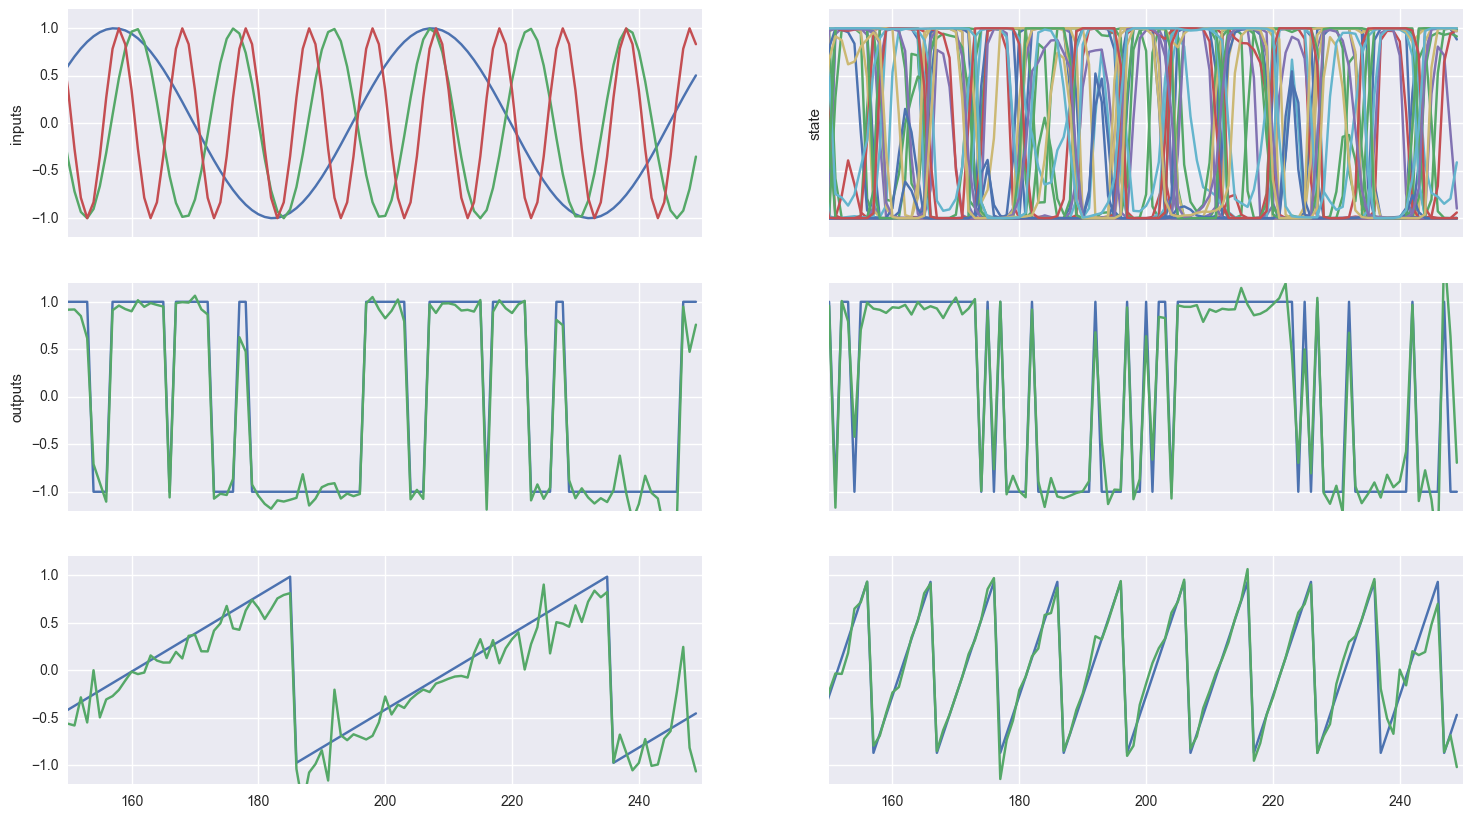

In [35]:
# Plot results
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='row', figsize=(18,10),
                                        subplot_kw=dict(xlim=(T-2*cycle,T),
                                                        ylim=(-1.2,1.2)))
# Row 1: inputs; state
ax1.plot(u_data)
ax1.set_ylabel("inputs")
ax2.plot(x_tf[:,0:30])
ax2.set_ylabel("state")

# Row 2, 3: outputs
ax3.plot(y_data[:,0])
ax3.plot(y_tf[:,0])
ax3.set_ylabel("outputs")
ax4.plot(y_data[:,1])
ax4.plot(y_tf[:,1])
ax5.plot(y_data[:,2])
ax5.plot(y_tf[:,2])
ax6.plot(y_data[:,3])
ax6.plot(y_tf[:,3])

plt.show()